# heatmaps in R

In [4]:
library(tidyverse)
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(circlize))
library(ComplexHeatmap)
library(circlize)
library(ggforce)
library(ROCR)
library(cowplot)

In [35]:
df_ddg <- read_csv('../data/20200806_gsp1_ddg.csv', col_types = cols())  # rosetta ddG scores
df_fit <- read_csv('../data/Gsp1_DMS_15gen_current.csv', col_types = cols())  # empiric fitnesses, binned
df_con <- read_csv('../data/conservation.csv', col_types = cols())       # conservation from consurf
df_bur <- read_csv('../data/burial.csv', col_types = cols())             # burial, based on SASA across all structures

aa_ordering <- c('W','Y','F','M','L','I','V','A','C','G',
                'P','T','S','Q','N','E','D','H','R','K','*')
bin_ordering <- c('drop-outs','toxic','STOP-like','intermediate','neutral','beneficial')
bin_colors <- setNames(as.list(c('black', RColorBrewer::brewer.pal(7, 'RdBu')[1:5])),
                       c('drop-outs','toxic','STOP-like','intermediate','neutral','beneficial'))

In [36]:
df <-
    df_fit %>%
    left_join(df_ddg, by = c('mutant'='mutation')) %>%
    left_join(df_con, by = c('position', 'aa_to')) %>%
    left_join(df_bur, by='position') %>%
    mutate('bin' = ifelse(bin=='NaN', 'drop-outs', bin)) %>%
    mutate('bin' = factor(bin, levels=bin_ordering),
           'aa_to'=factor(aa_to, levels=aa_ordering),
           'aa_from'=factor(aa_from, levels=aa_ordering)) %>%
    rename('fitness'=score)


# prepare a sequence vector for WT Gsp1 so we can box cells in heatmaps that are WT in sequence (i.e. T34T)
gsp1_seq <- select(df, aa_from, position) %>% unique() %>% pull(aa_from) %>% as.character()

# convert dataframes to matrices for each dataset, for plotting
mat <- 
  df %>%
  select(position, aa_to, fitness) %>%
  pivot_wider(id_cols = aa_to, names_from = position, values_from = fitness) %>%
  arrange(desc(aa_to)) %>%
  column_to_rownames('aa_to') %>%
  as.matrix()

In [37]:
gp_font = gpar(fontsize = 12, fontfamily='Helvetica')

##### HEATMAPS #####

# function for plotting a heatmap of empiric data
# input dataset should be a matrix, with 21 aa labels as rows
# and each residue position as columns
draw_fitness_heatmap <- function(mat, name, col, label_WT = F, sequence=NULL) {
  Heatmap(mat, name=name, col=col, show_heatmap_legend = T, na_col='black',
          
    row_title = 'Amino Acid Substituted', cluster_rows = F, row_names_side = 'left',
    row_title_gp = gp_font, row_names_gp = gp_font,

    column_title = 'Gsp1 sequence position', cluster_columns = F,
    column_title_gp = gp_font, column_names_gp = gp_font,
    column_names_side = 'top',
#     column_labels = replace(colnames(mat), seq(from = 2, to = length(colnames(mat)), by = 2), ''),

     # borders around all
    cell_fun = function(j, i, x, y, width, height, fill) {
        if ((rownames(mat)[i] == sequence[j]) & label_WT) {
            grid.rect(x, y, width, height, gp = gpar(col = 'green', lwd = 3, fill = "transparent"))
        } else {
            grid.rect(x, y, width, height, gp = gpar(col = 'black', lwd = 0.5, fill = "transparent"))
        } 
      },
          
    bottom_annotation = HeatmapAnnotation(
        which='column','sequence'=anno_text(sequence, rot=0, just = "center", location = 0.5))
  )
}

# col_fn <- colorRamp2(seq(-2.5, 1.5, by=0.5), RColorBrewer::brewer.pal(11, 'RdBu')[1:9])
col_fn <- colorRamp2(seq(-5, 3, by=1), RColorBrewer::brewer.pal(11, 'RdBu')[1:9])

# make heatmaps
hm1 <- draw_fitness_heatmap(mat[1:21,1:110], 'Fitness', col_fn, label_WT=F, sequence=gsp1_seq[1:110])
hm2 <- draw_fitness_heatmap(mat[1:21,111:220], 'Fitness', col_fn, label_WT=F, sequence=gsp1_seq[111:220])


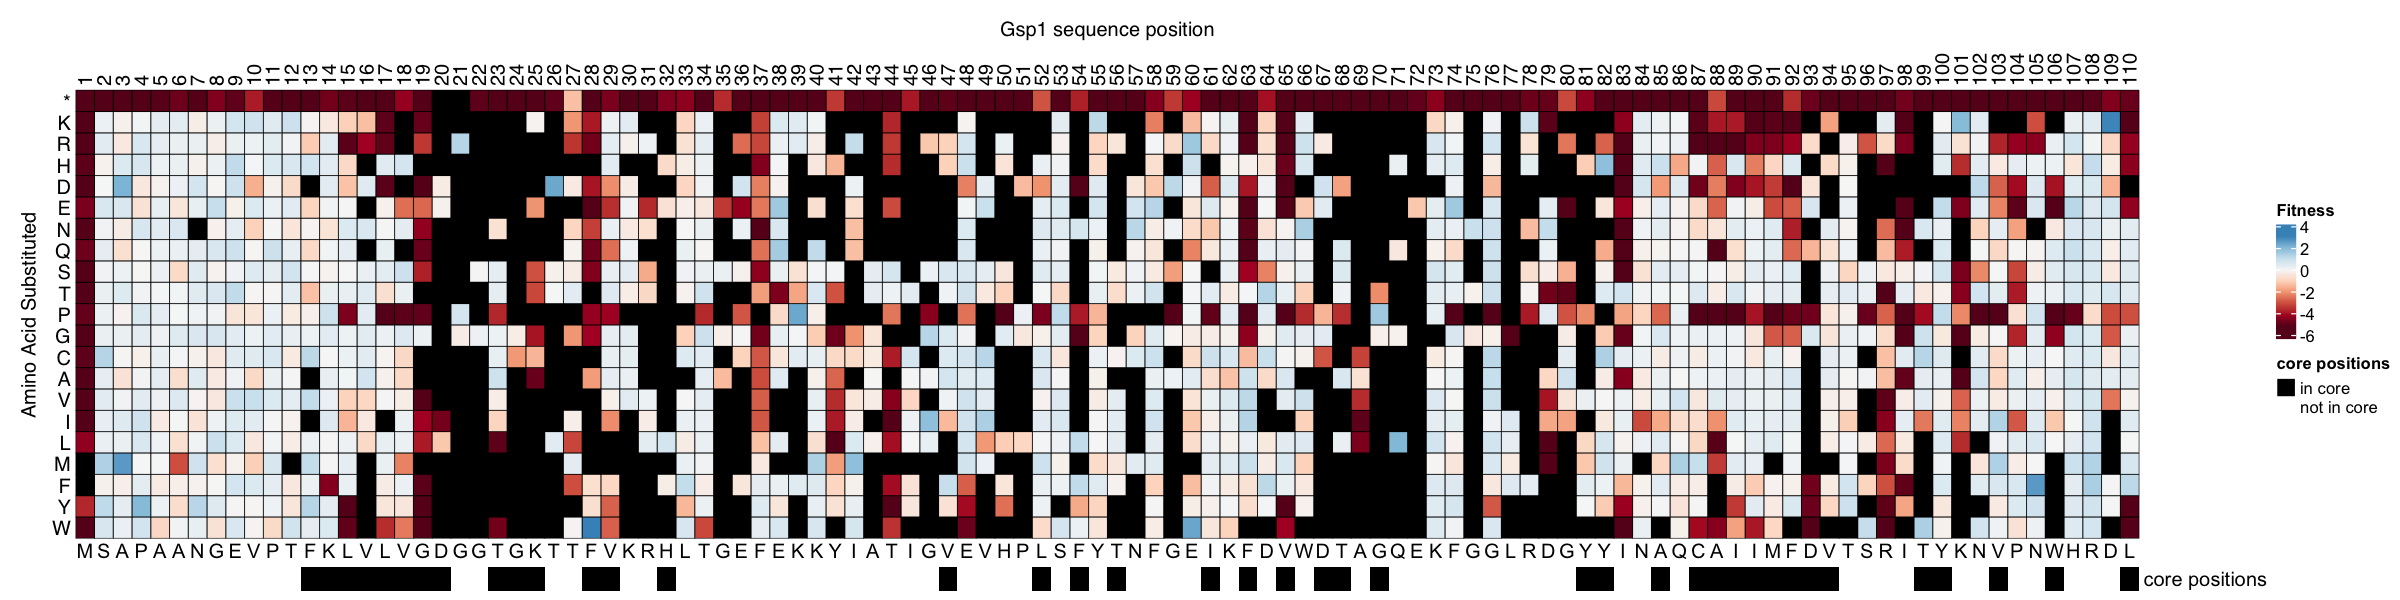

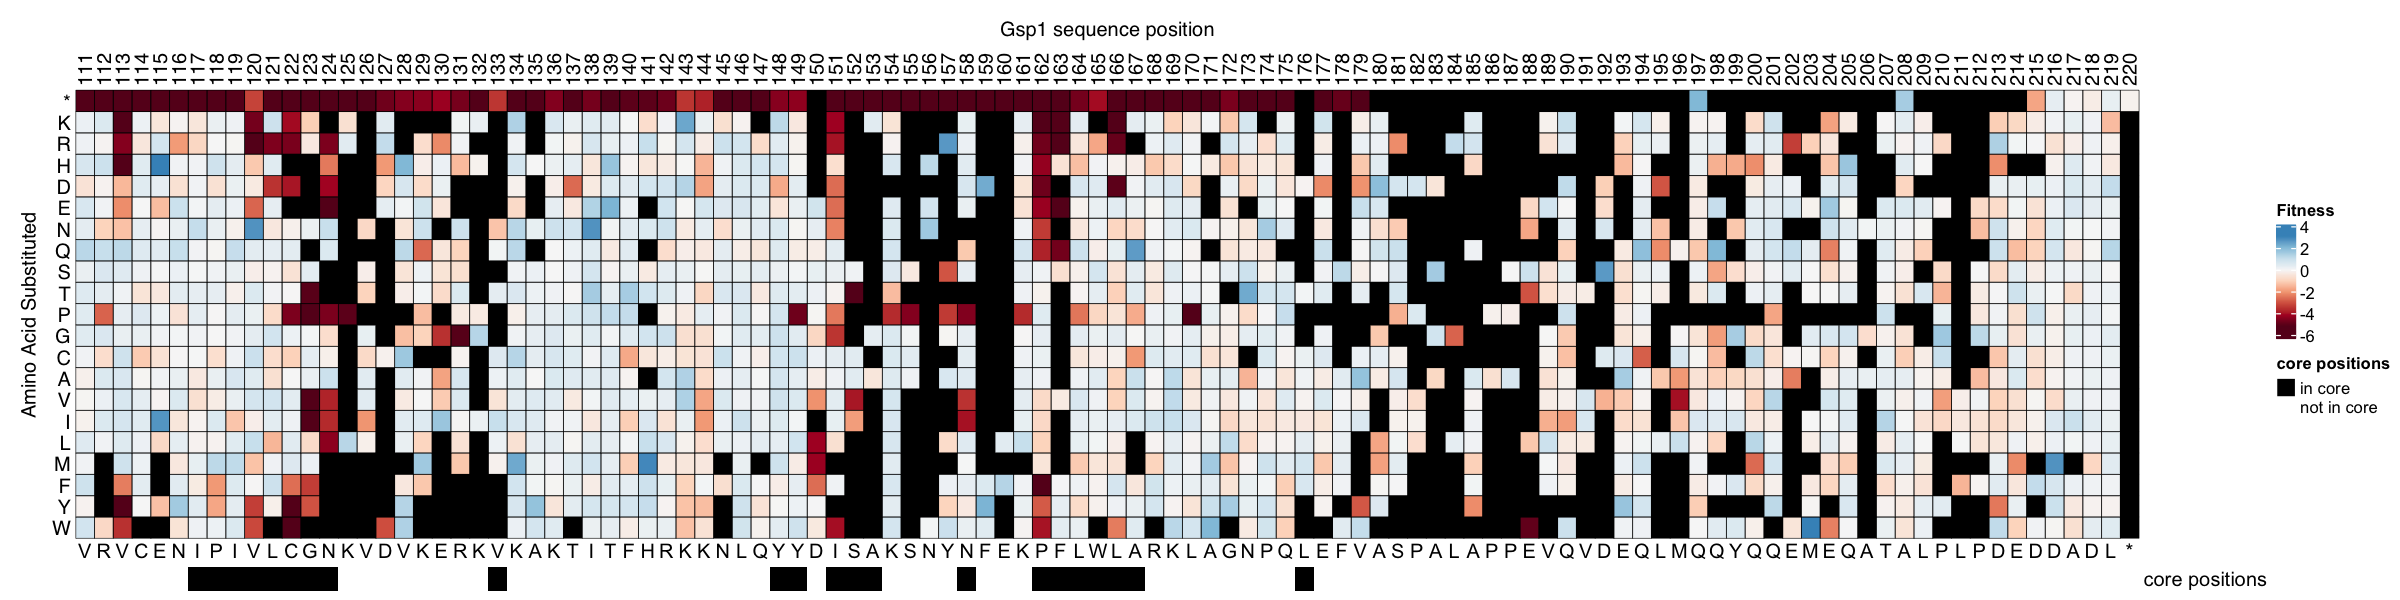

In [38]:
### Annotations
in_core <- df %>%
    select(position, sasa_group_category) %>%
    unique() %>%
    mutate(in_core = case_when(sasa_group_category=='structure core' ~ 'in core',
                               is.na(sasa_group_category) ~ 'not in core',
                               TRUE ~ 'not in core')) %>%
    pull(in_core)

core_annot1 <- columnAnnotation(
    'core positions'=in_core[1:110],
    col=list('core positions'=c('in core' = 'black','not in core' = 'white'))
)
core_annot2 <- columnAnnotation(
    'core positions'=in_core[111:220],
    col=list('core positions'=c('in core' = 'black','not in core' = 'white'))
)

# how handle different halves of plot

# mean_annot = HeatmapAnnotation(
#   `Mean 15gen` = colMeans(mat_15gen, na.rm = T, dims = 1), show_legend = F,
#   col = list(`Mean 15gen` = col_fn),
#   which = 'column', simple_anno_size = unit(2, 'mm'), annotation_name_side = 'left')

# # make annotation of secondary structure
# ss_annot = HeatmapAnnotation(
#   `secondary structure` = empiric %>%
#     select(position, consensus_ss) %>%
#     unique() %>%
#     column_to_rownames('position') %>%
#     as.matrix(),
#   show_annotation_name = F, simple_anno_size = unit(2, 'mm'),
#   # NOTE for color: NA is also gray (should only be stop codon at position 220)
#   col = list(`secondary structure` = c('L' = 'gray', 'H' = 'orange', 'E' = 'purple')),
#   annotation_legend_param = list('nrow'=1)
# )

options(repr.plot.width=20, repr.plot.height=5)
hm1 %v% core_annot1
hm2 %v% core_annot2

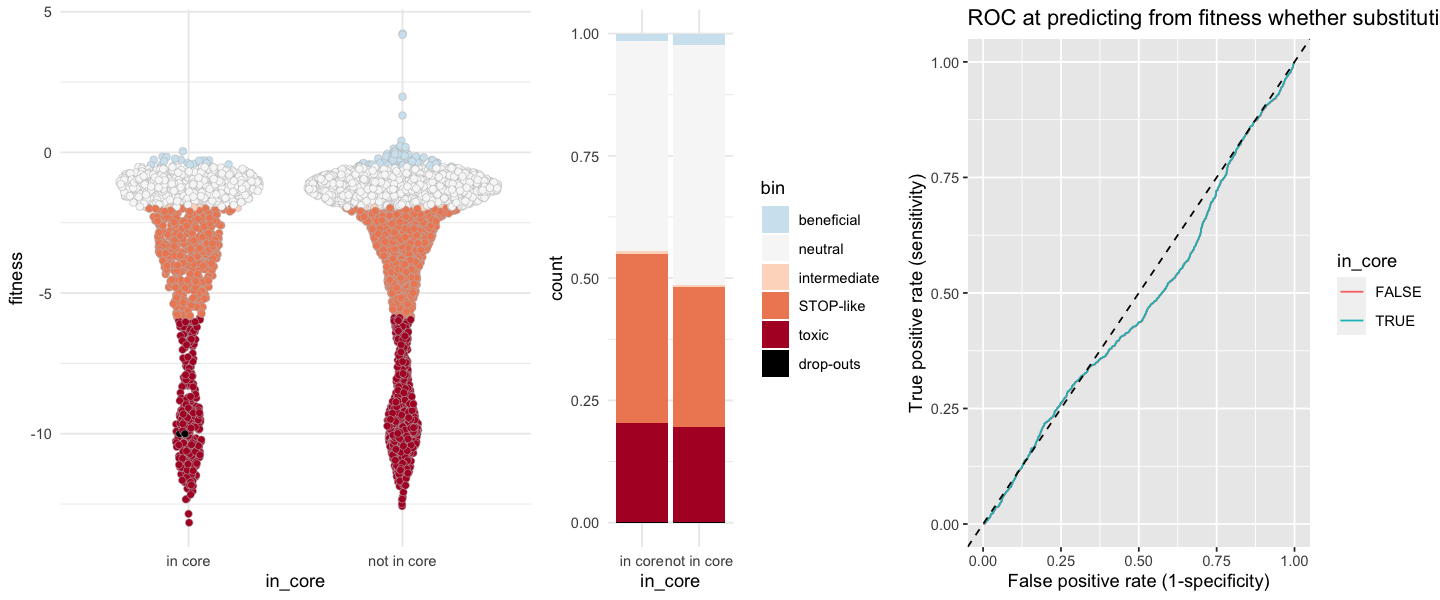

In [34]:
p1 <- df %>%
    mutate(in_core = case_when(sasa_group_category=='structure core' ~ 'in core',
                               is.na(sasa_group_category) ~ 'not in core',
                               TRUE ~ 'not in core')) %>%
    mutate(fitness = ifelse(is.na(fitness), -10, fitness)) %>%
    ggplot(aes(x=in_core, y=fitness, fill=bin, group=in_core)) +
        geom_sina(shape=21, stroke=0.2, size=2, color='gray',
                  show.legend=F) +
        scale_fill_manual(values = bin_colors) +
        theme_minimal()

p2 <- df %>%
    mutate(in_core = case_when(sasa_group_category=='structure core' ~ 'in core',
                               is.na(sasa_group_category) ~ 'not in core',
                               TRUE ~ 'not in core'),
           bin = fct_rev(bin)) %>%
    ggplot(aes(x=in_core, fill=bin)) +
        geom_bar(position = "fill") +        
        scale_fill_manual(values = rev(bin_colors)) +
        theme_minimal()


# roc code from https://rpubs.com/sergiouribe/ROC

roc <-
    df %>%
    mutate(in_core = case_when(sasa_group_category=='structure core' ~ TRUE,
                               is.na(sasa_group_category) ~ FALSE,
                               TRUE ~ FALSE)) %>%
    select(mutant, in_core, fitness) %>% 
    group_by(in_core, fitness) %>% 
    summarise(Positive = sum(in_core), 
              Negative = n() - sum(in_core),
              .groups='drop') %>%
  arrange(-fitness) %>% 
  mutate(TPR = cumsum(Positive) / sum(Positive), 
         FPR = cumsum(Negative) / sum(Negative))

p3 <- roc %>% 
  ggplot(aes( x= FPR, y = TPR, color = in_core)) +
  geom_line() +
  geom_abline(lty = 2) +
  xlab("False positive rate (1-specificity)") + 
  ylab("True positive rate (sensitivity)") +
  ggtitle("ROC at predicting from fitness whether substitution is in the core")

options(repr.plot.width=12, repr.plot.height=5)

plot_grid(p1, p2, p3, nrow = 1, rel_widths = c(3,2,3))

sing a 5Å cutoff between heavy atoms, the following residues are in contact with the nucleotide

- 19-28
- 37-44
- 67-71
- 124-125
- 127-128
- 152-154

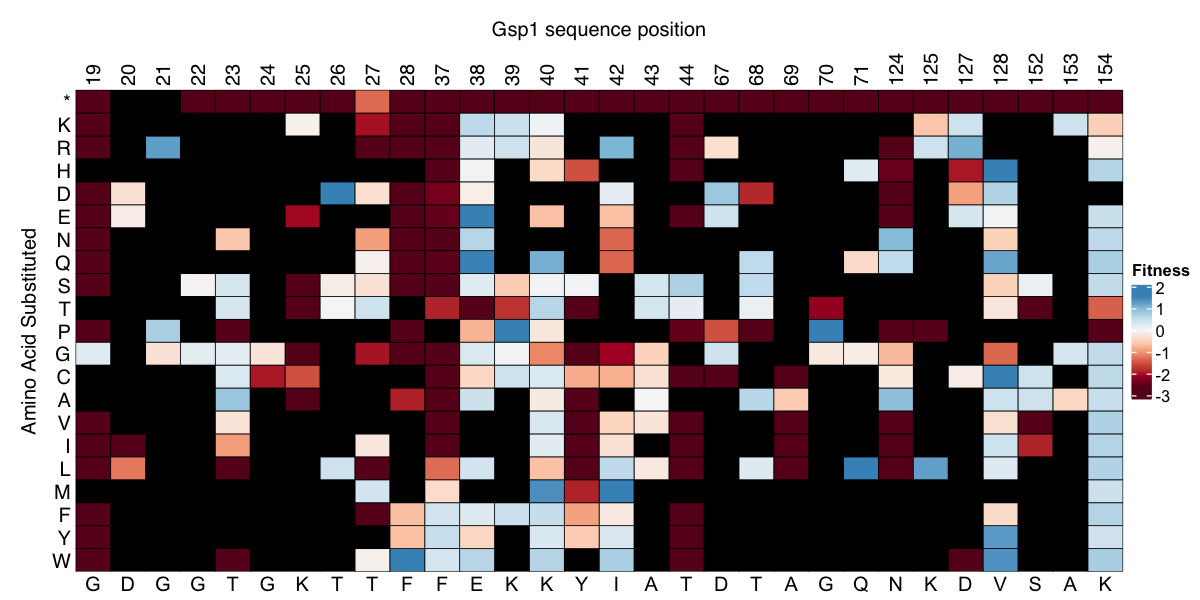

In [9]:
active_site = c(seq(19,28),seq(37,44),seq(67,71),124,125,127,128,seq(152,154))

options(repr.plot.width=10, repr.plot.height=5)

draw_fitness_heatmap(mat[,active_site], 'Fitness', col_fn, label_WT=F, sequence=gsp1_seq[active_site])

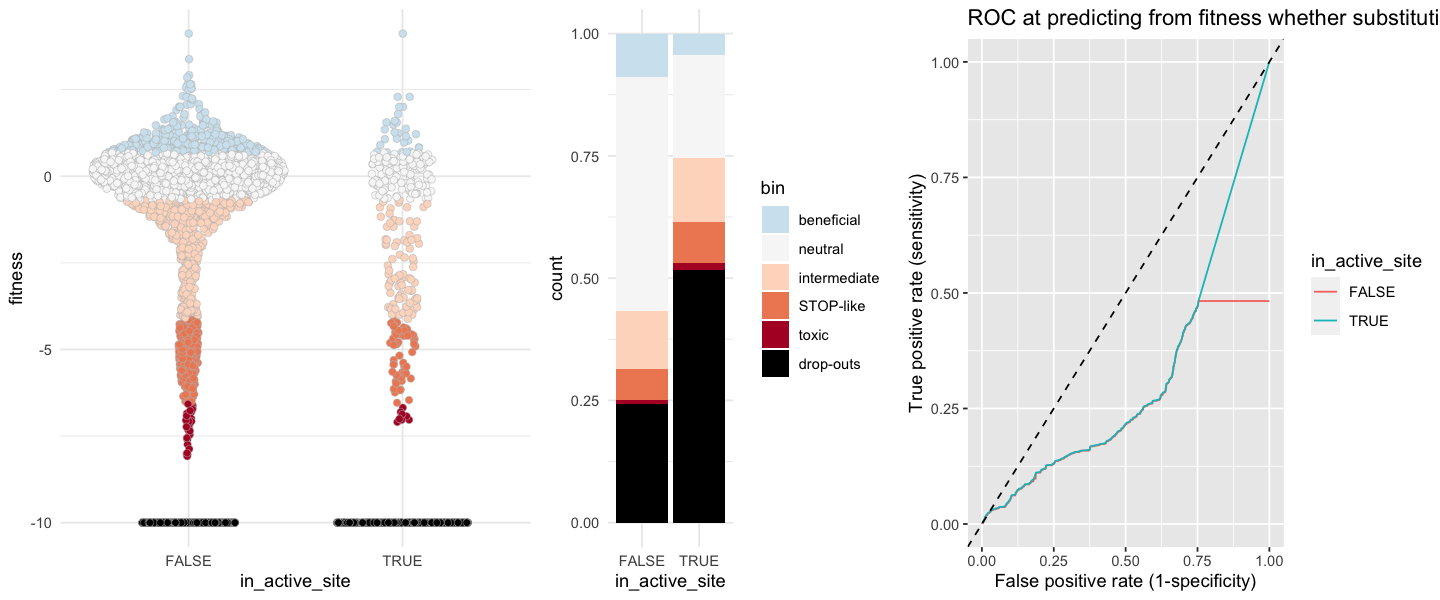

In [10]:
p1 <- df %>%
    mutate(in_active_site = ifelse(position %in% active_site, T, F)) %>%
    mutate(fitness = ifelse(is.na(fitness), -10, fitness)) %>%
    ggplot(aes(x=in_active_site, y=fitness, fill=bin, group=in_active_site)) +
        geom_sina(shape=21, stroke=0.2, size=2, color='gray',
                  show.legend=F) +
        scale_fill_manual(values = bin_colors) +
        theme_minimal()



p2 <- df %>%
    mutate(in_active_site = ifelse(position %in% active_site, T, F),
           bin = fct_rev(bin)) %>%
    ggplot(aes(x=in_active_site, fill=bin)) +
        geom_bar(position = "fill") +        
        scale_fill_manual(values = rev(bin_colors)) +
        theme_minimal()


# roc code from https://rpubs.com/sergiouribe/ROC

roc <-
    df %>%
    mutate(in_active_site = ifelse(position %in% active_site, T, F)) %>%
    select(mutant, in_active_site, fitness) %>% 
    group_by(in_active_site, fitness) %>% 
    summarise(Positive = sum(in_active_site), 
              Negative = n() - sum(in_active_site),
              .groups='drop') %>%
  arrange(-fitness) %>% 
  mutate(TPR = cumsum(Positive) / sum(Positive), 
         FPR = cumsum(Negative) / sum(Negative))

p3 <- roc %>% 
  ggplot(aes( x= FPR, y = TPR, color = in_active_site)) +
  geom_line() +
  geom_abline(lty = 2) +
  xlab("False positive rate (1-specificity)") + 
  ylab("True positive rate (sensitivity)") +
  ggtitle("ROC at predicting from fitness whether substitution is in the core")

options(repr.plot.width=12, repr.plot.height=5)

plot_grid(p1, p2, p3, nrow = 1, rel_widths = c(3,2,3))

extending the shell to 6Å adds 45, 74, 91, 126, 155

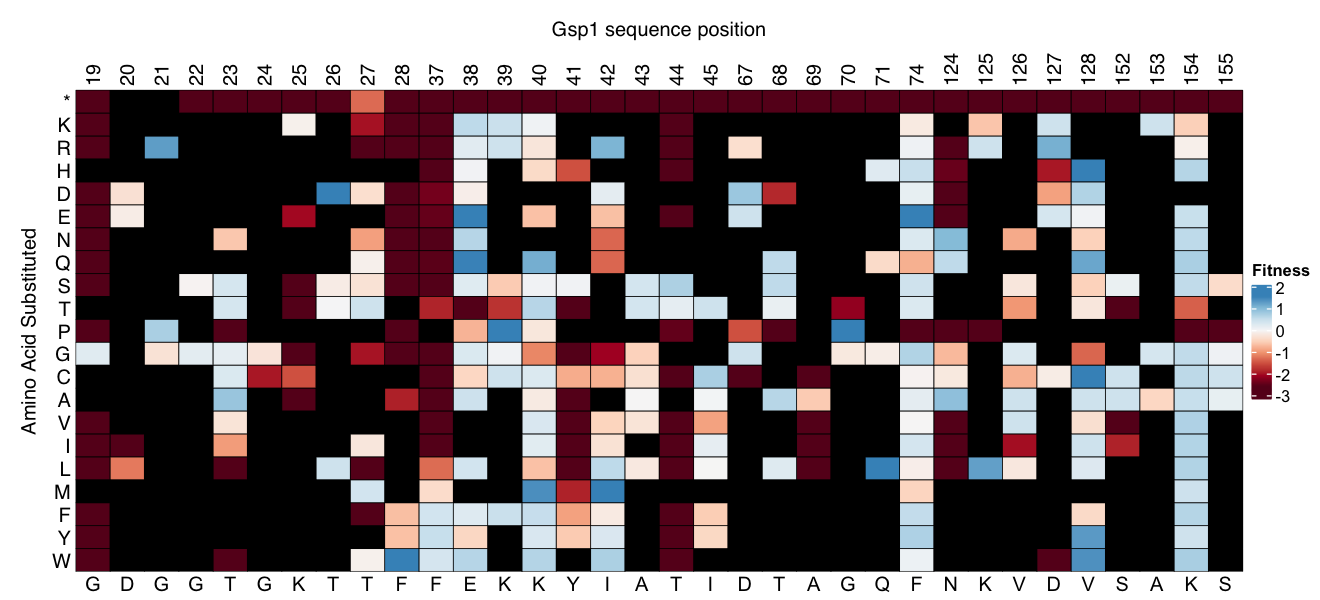

In [16]:
active_site = c(seq(19,28),seq(37,45),seq(67,71),74,seq(124,128),seq(152,155))

options(repr.plot.width=11, repr.plot.height=5)

draw_fitness_heatmap(mat[,active_site], 'Fitness', col_fn, label_WT=F, sequence=gsp1_seq[active_site])

In [29]:
df_dom = read_csv('../data/dominant_mutations.csv', col_types=cols())

df2 <- 
    df %>% 
    group_by(position) %>% 
    mutate(fitness = ifelse(is.na(fitness), -10, fitness),
           median_fitness = median(fitness)) %>% 
    ungroup() %>% 
    select(aa_from, position, region3, sasa_group_category, median_fitness) %>% 
    unique() %>% 
    left_join(df_dom, by='position') %>% 
    replace_na(list(n_dom_del = 0))

In [31]:
head(df2)

aa_from,position,region3,sasa_group_category,median_fitness,n_dom_del
<fct>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
M,1,effector surface,surface,-5.5141095,0
S,2,effector surface,surface,0.2710200,0
A,3,effector surface,surface,0.1741950,0
P,4,effector mixed,mixed,0.3685328,0
A,5,effector surface,surface,0.1664849,0
A,6,effector interface core,interface core,0.0582380,0


In [32]:
contacting_residues = c(19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 37, 38, 39, 40, 41, 42,
                        43, 44, 67, 68, 69, 70, 71, 124, 125, 127, 128, 152, 153, 154)


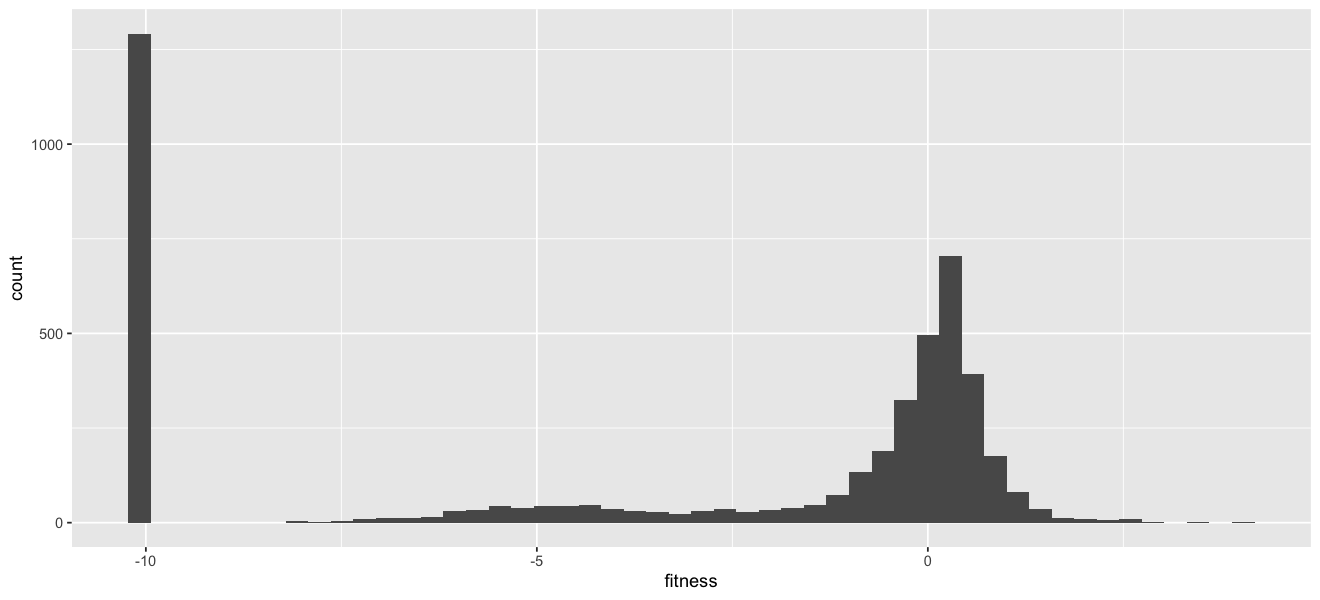

In [48]:
df %>%
    mutate(fitness = ifelse(is.na(fitness), -10, fitness)) %>% 
    ggplot(aes(x=fitness)) + geom_histogram(bins = 50)

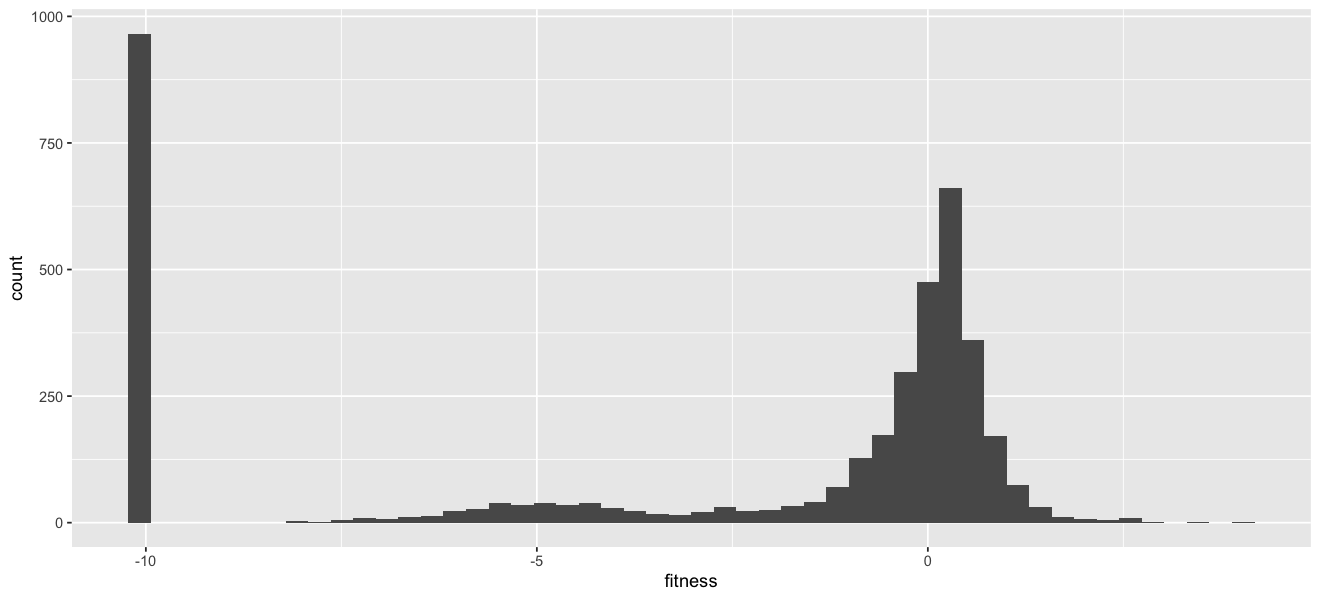

In [49]:
df %>% 
    mutate(fitness = ifelse(is.na(fitness), -10, fitness)) %>% 
    filter(! position %in% contacting_residues) %>% 
    ggplot(aes(x=fitness)) + geom_histogram(bins = 50)

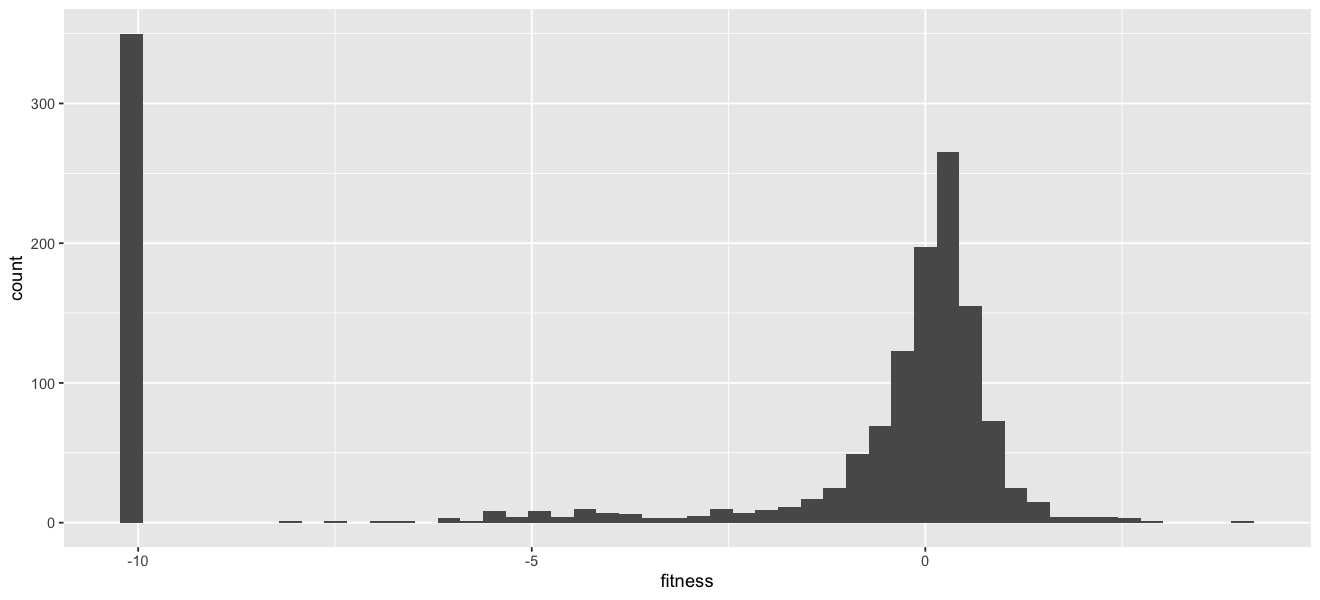

In [52]:
df %>% 
    mutate(fitness = ifelse(is.na(fitness), -10, fitness)) %>% 
    filter(! position %in% contacting_residues,
           ! ddg > 1) %>% 
    ggplot(aes(x=fitness)) + geom_histogram(bins = 50)

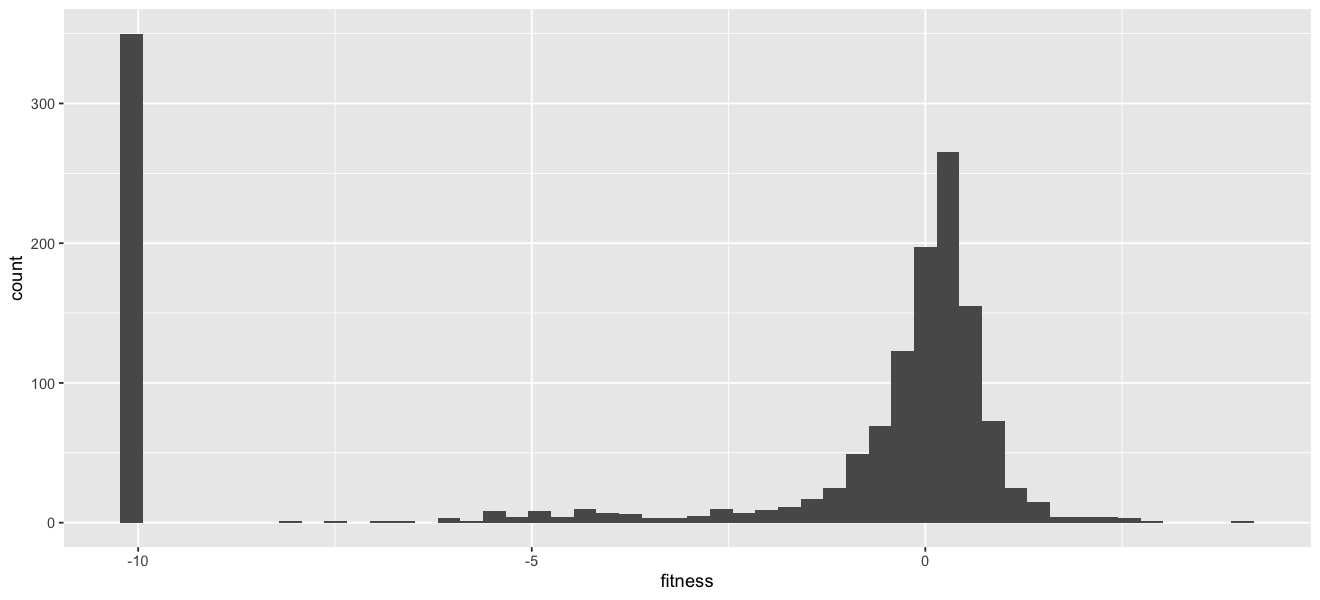

In [59]:
df %>% 
    mutate(fitness = ifelse(is.na(fitness), -10, fitness)) %>% 
    filter(! position %in% contacting_residues,
           ! ddg > 1,
#            ! sasa_group_category == 'structure core'
          ) %>% 
    ggplot(aes(x=fitness)) + geom_histogram(bins = 50)

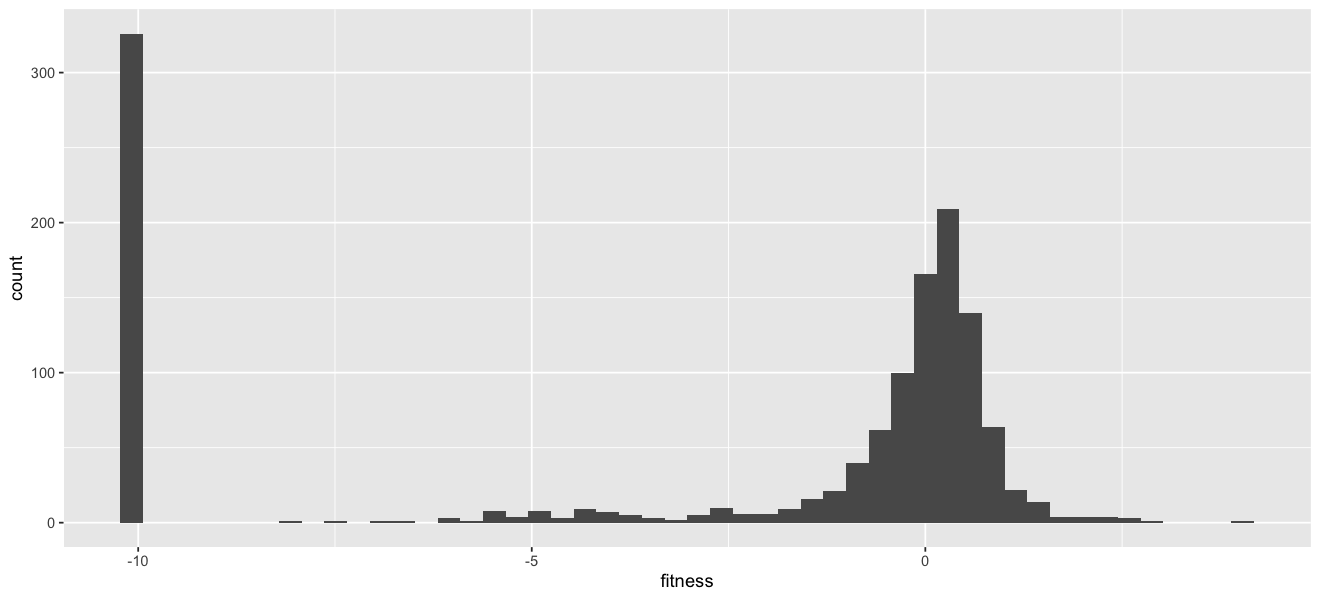

In [60]:
df %>% 
    mutate(fitness = ifelse(is.na(fitness), -10, fitness)) %>% 
    filter(! position %in% contacting_residues,
           ! ddg > 1,
           ! sasa_group_category == 'structure core'
          ) %>% 
    ggplot(aes(x=fitness)) + geom_histogram(bins = 50)